In [25]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Reshape
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [29]:
df = pd.read_csv('./datasets/KRPUS_CNDAG/05e4d21a-31a0-3476-adf8-792558757ade.csv')
print(df.shape)
display(df.head(3))

(268, 12)


VSL_ID            TIMESTAMP  SPEED    COG  \
0  05e4d21a-31a0-3476-adf8-792558757ade  2024-12-13 14:00:31    5.0  211.5   
1  05e4d21a-31a0-3476-adf8-792558757ade  2024-12-13 14:10:02    8.8  124.6   
2  05e4d21a-31a0-3476-adf8-792558757ade  2024-12-13 14:20:51    9.2  125.7   

   HEADING  DRAFT              NAV_STATUS        LAT         LON DESTINATION  \
0    208.0    5.9                  MOORED  35.120610  129.063040      CN DLC   
1    124.0    5.9  UNDER_WAY_USING_ENGINE  35.103953  129.067067      CN DLC   
2    125.0    5.9  UNDER_WAY_USING_ENGINE  35.087313  129.095240      CN DLC   

  UNLOCODE                  ETA  
0    CNDLC  2024-12-16 09:00:00  
1    CNDLC  2024-12-16 09:00:00  
2    CNDLC  2024-12-16 09:00:00

# ÌïòÏù¥Ìçº ÌååÎùºÎØ∏ÌÑ∞

In [31]:
TRAIN_SPLIT = 160  # (Í∏∞Î≥∏)len(df)*0.8
BATCH_SIZE = 18
EPOCH = 20
WEIGHT_UPDATE_INTERVAL = 11 #186 / 8 = 14...
VALIDATION_INTERVAL =  5 # (233 - TRAIN_SPLIT) // BATCH_SIZE
# BUFFER_SIZE = 230 #TRAIN_SPLITÍ≥º Í∞ôÍ±∞ÎÇò ÌÅº

# Î∂ÑÏÑùÌï† Ïª¨Îüº Ï∂îÏ∂ú Î∞è ÏãúÍ∞Ñ Îç∞Ïù¥ÌÑ∞(ÌòïÌÉúÎ≥ÄÌôò, ÏãúÏ†êÍ∞úÏàò)

In [33]:
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
df = df.sort_values('TIMESTAMP')
features = df[['TIMESTAMP','LAT','LON']]
features.set_index('TIMESTAMP', inplace=True)
display(features.head())
print(features.shape)

LAT         LON
TIMESTAMP                                 
2024-12-13 14:00:31  35.120610  129.063040
2024-12-13 14:10:02  35.103953  129.067067
2024-12-13 14:20:51  35.087313  129.095240
2024-12-13 14:30:21  35.071070  129.114053
2024-12-13 14:40:30  35.047667  129.129880

(268, 2)


In [35]:
# ÏÜåÏöîÏãúÍ∞Ñ
print('ÏÜåÏöîÏãúÍ∞Ñ', df['TIMESTAMP'].max() - df['TIMESTAMP'].min())

ÏÜåÏöîÏãúÍ∞Ñ 2 days 14:57:31


In [37]:
df['hour'] = df['TIMESTAMP'].dt.floor('H')         # ÏãúÍ∞ÑÏùÑ Í∏∞Ï§ÄÏúºÎ°ú ÏûêÎ•¥Í∏∞ (Î∂Ñ/Ï¥à Ï†úÍ±∞)

hourly_counts = df.groupby('hour').size()
print(np.round(hourly_counts.mean(), 2))
# Îç∞Ïù¥ÌÑ∞ Í∞Ñ Í∞ÑÍ≤©ÏùÄ ÏïΩ 6Î∂Ñ Í∞ÑÍ≤© (60 / 10 = 6)

4.25


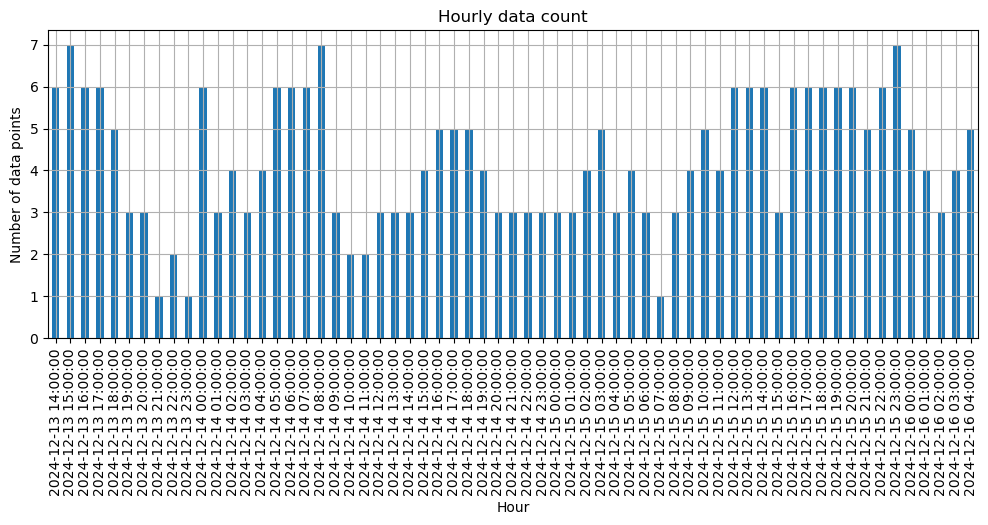

In [39]:
# (Ï∞∏Í≥†) Ìïú ÏãúÍ∞Ñ Îãπ Îç∞Ïù¥ÌÑ∞Ïùò Í∞úÏàò ÌôïÏù∏ ÏãúÍ∞ÅÌôî
import matplotlib.pyplot as plt

hourly_counts.plot(kind='bar', figsize=(12, 4))
plt.title("Hourly data count")
plt.xlabel("Hour")
plt.ylabel("Number of data points")
plt.grid(True)
plt.show()

# ÌëúÏ§Ä

In [41]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(features)

# ÌÉÄÏûÑ Ïä§ÌÖùÎ≥Ñ Îç∞Ïù¥ÌÑ∞ Î∂ÑÎ¶¨ Ìï®Ïàò

In [43]:
def multivariate_data(dataset, target, start_index, end_index, history_size, target_size, step, single_step=False):
    data, labels = [], []
    start_index += history_size

    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indexes = range(i - history_size, i, step)
        data.append(dataset[indexes])

        if single_step:
            labels.append(target[i + target_size])
        else:
            labels.append(target[i : i+target_size])

    return np.array(data), np.array(labels)

# Ïû•Í∏∞ÏòàÏ∏°Ïù¥ÎØÄÎ°ú single_step=False

# ÌÉÄÏûÑ Ïä§ÌÖùÎ≥Ñ ÎèÖÎ¶ΩÎ≥ÄÏàòÏôÄ Ï¢ÖÏÜçÎ≥ÄÏàò Ï∂îÏ∂ú

In [207]:
past_history = 40 #Í≥ºÍ±∞ 4ÏãúÍ∞Ñ (Ìïú ÏãúÍ∞ÑÏóê 10Í∞ú * 4) # Ïà´Ïûê ÏàòÏ†ï - 1ÏãúÍ∞ÑÏóê 10Í∞úÎãàÍπå 10Îã®ÏúÑÎ°ú ÎÅäÏñ¥Ï†∏Ïïº Ìï®
future_target =15 #ÎØ∏Îûò 1.5ÏãúÍ∞Ñ (Ìïú ÏãúÍ∞ÑÏóê 10Í∞ú * 1.5)
step = 1
# ÏÑ†Î∞ïÏùò Ï¥ù ÏÜåÏöîÏãúÍ∞ÑÏùÑ ÌååÏïÖ ÌõÑ 

X_train_single, y_train_single = multivariate_data(scaled, scaled, start_index=0, end_index=TRAIN_SPLIT, history_size=past_history, target_size=future_target, step=step, single_step=True)

X_val_single, y_val_single = multivariate_data(scaled, scaled, start_index=TRAIN_SPLIT, end_index=None, history_size=past_history, target_size=future_target, step=step, single_step=True)

In [146]:
print(X_train_single.shape) # shape[0]Í∞úÏùò ÌïôÏäµ ÏÉòÌîå, Í∞Å ÏÉòÌîåÏùÄ (LAT, LON)
print(y_train_single.shape) # shape[0]Í∞úÏùò ÎØ∏Îûò ÏòàÏ∏°Í∞í, 10ÏãúÏ†ê ÏòàÏ∏°Í∞íÏù¥ LAT/LON Ìè¨Ìï®ÎêòÏñ¥ ÏûàÏùå
print(X_val_single.shape) # Í≤ÄÏ¶ùÏö© ÏûÖÎ†• 22Í∞ú ÏÉòÌîå, Í∞Å ÏÉòÌîåÏùÄ (LAT, LON)
print(y_val_single.shape)
# Í≤ÄÏ¶ùÏö© Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ± ÏïàÎê† Ïãú, TRAIN_SPLIT = len(scaled) - (past_history + future_target) Í∞í Î≥ÄÍ≤Ω

(120, 40, 2)
(120, 2)
(53, 40, 2)
(53, 2)


# ÌïôÏäµ Î∞è ÌèâÍ∞Ä Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ±

In [149]:
train_data_single = tf.data.Dataset.from_tensor_slices((X_train_single, y_train_single)).cache().shuffle(X_train_single.shape[0]).batch(BATCH_SIZE, drop_remainder=True).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((X_train_single, y_train_single)).cache().shuffle(X_train_single.shape[0]).batch(BATCH_SIZE, drop_remainder=True).repeat()

# LSTM Î™®Îç∏ ÏÉùÏÑ± Î∞è ÌïôÏäµ

In [151]:
single_step_model = Sequential()
single_step_model.add(LSTM(64, input_shape=X_train_single.shape[-2:]))
# single_step_model.add(LSTM(32, activation='relu'))
single_step_model.add(Dense(2))
# single_step_model.add(Reshape(((future_target, 2))))
single_step_model.compile(optimizer='adam', loss='mse') #WGA

In [153]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

single_step_history = single_step_model.fit(train_data_single, epochs=EPOCH, steps_per_epoch=WEIGHT_UPDATE_INTERVAL, validation_data=val_data_single, validation_steps=VALIDATION_INTERVAL, callbacks=[early_stop])

Epoch 1/20
11/11 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 67ms/step - loss: 0.0796 - val_loss: 0.0226
Epoch 2/20
11/11 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 26ms/step - loss: 0.0165 - val_loss: 0.0039
Epoch 3/20
11/11 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 23ms/step - loss: 0.0040 - val_loss: 0.0024
Epoch 4/20
11/11 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 24ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 5/20
11/11 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 23ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 6/20
11/11 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 24ms/step - loss: 0.0011 - val_loss: 8.9383e-04
Epoch 7/20
11/11 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 30ms/step - loss: 9.1061e-04 - val_loss: 8.7309e-04
Epoch 8/20
11/11 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 23ms/step - loss: 9.1106e-04 - v

# ÏòàÏ∏° Í≤∞Í≥º ÏãúÍ∞ÅÌôî Ìï®Ïàò

In [156]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    past_history = range(-len(history), 0)
    future = len(true_future)

    plt.plot(past_history, history, '.-', label='History')
    plt.plot(np.arange(future) / 5, true_future, 'ro', label='True_future')
    plt.plot(np.arange(future) /  5, prediction, 'go', label='Predicted_future')
    plt.legend()
    plt.xlabel('Time-Step')
    plt.grid(True)
    plt.show()

# Ïó≠Ï†ïÍ∑úÌôî Ìï®Ïàò & ÏãúÍ∞ÅÌôî Ìï®Ïàò ÏÇ¨Ïö©

In [158]:
# Ïó≠Ï†ïÍ∑úÌôî Ìï®Ïàò
def inverse_coords(arr_3d, scaler):
    flat = arr_3d.reshape(-1, 2)
    inv = scaler.inverse_transform(flat)
    return inv.reshape(arr_3d.shape)

# ÏãúÍ∞ÅÌôî Ìï®Ïàò ÏÇ¨Ïö©
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    past_history = range(-len(history), 0)
    future = len(true_future)

    plt.plot(past_history, history, '.-', label='History')
    plt.plot(np.arange(future) / 5, true_future, 'ro', label='True_future')
    plt.plot(np.arange(future) /  5, prediction, 'go', label='Predicted_future')
    plt.legend()
    plt.xlabel('Time-Step')
    plt.grid(True)
    plt.show()

# Ï†ÑÏ≤¥ Í≤ΩÎ°ú Í∑∏Î¶¨Í∏∞

In [160]:
def plot_path(actual_path, pred_path):
    plt.figure(figsize=(8,5))
    plt.plot(actual_path[:,1], actual_path[:,0], 'r', label='actual path')
    plt.plot(pred_path[:,1], pred_path[:,0], 'b', label='pred path')
    plt.legend()
    plt.grid(True)
    plt.show()

## Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞Ïóê ÎåÄÌïú Î∂ÑÌï†

In [162]:
X_, y_ = multivariate_data(scaled, scaled, start_index=0, end_index=None, history_size=past_history, target_size=future_target, step=step, single_step=True)

## Ï†ÑÏ≤¥ Í≤ΩÎ°úÏóê ÎåÄÌïú ÏòàÏ∏° Í≤ΩÎ°ú / Ïã§Ï†ú Í≤ΩÎ°ú
- Ïã§Ï†ú Í≤ΩÎ°ú: actual_path
- ÏòàÏ∏° Í≤ΩÎ°ú: pred_path

In [164]:
actual_path = features.values
pred_path = single_step_model.predict(X_)
pred_path = inverse_coords(pred_path, scaler)

7/7 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 75ms/step


In [165]:
pred_path.shape, actual_path.shape

((213, 2), (268, 2))

# ÏßÄÎèÑÏóê ÏãúÍ∞ÅÌôî

In [167]:
# Ïã§Ï†ú Í≤ΩÎ°ú
import folium
from folium import PolyLine

true_coords = list(zip(df['LAT'], df['LON']))
center_lat = df['LAT'].mean()
center_lon = df['LON'].mean()

# ÏßÄÎèÑ Í∞ùÏ≤¥ ÏÉùÏÑ±
m = folium.Map(location=[center_lat, center_lon], zoom_start=9)

# Ïã§Ï†ú Í≤ΩÎ°ú ÏÑ† Í∑∏Î¶¨Í∏∞
folium.PolyLine(true_coords, color='red', weight=4, tooltip='Actual Path').add_to(m)

# ÏòàÏ∏° Í≤ΩÎ°ú ÏÑ† Í∑∏Í∏∞Í∏∞
pred_path = np.array(pred_path)
#print(pred_path)
folium.PolyLine(pred_path, color='green', weight=4, tooltip='Predicted Path').add_to(m)

# ÏßÄÎèÑ Ïã§Ìñâ
display(m)

# Í≤∞Ï†ïÍ≥ÑÏàò ÌôïÏù∏

In [169]:
from sklearn.metrics import r2_score

print('LAT R2-Score:%.3f'%r2_score(actual_path[55:,0], pred_path[:,0]))
print('LON R2-Score:%.3f'%r2_score(actual_path[55:,1], pred_path[:,1]))
# actual_path[X:,0] -> X: past_history + future_target

LAT R2-Score:0.966
LON R2-Score:0.966


# Î™®Îç∏ Ï†ÄÏû•

In [172]:
single_step_model.save('CNDAG_model.keras')

# Ïò§Ï∞® Í≥ÑÏÇ∞ Î∞è ÏãúÍ∞ÅÌôî Ìï®Ïàò

In [175]:
import numpy as np
import matplotlib.pyplot as plt

def plot_prediction_errors(actual_path, pred_path):
    """
    Ïã§Ï†úÍ∞í(actual_path)Í≥º ÏòàÏ∏°Í∞í(pred_path)ÏùÑ ÎπÑÍµêÌïòÏó¨ Ïò§Ï∞® ÏãúÍ∞ÅÌôî
    - actual_path, pred_path: shape (N, 2) [LAT, LON]
    """
    # 1. Ïò§Ï∞® Í≥ÑÏÇ∞
    offset = len(actual_path) - len(pred_path)
    actual_aligned = actual_path[offset:]  # Ïã§Ï†ú Í≤ΩÎ°ú Îí§Ï™Ω ÏûêÎ•¥Í∏∞ (ÏòàÏ∏°Ïóê ÎßûÏ∂§)

    # actual_pathÏôÄ pred_path Í∏∏Ïù¥ ÎßûÏ∂∞ Ïò§Ï∞® Í≥ÑÏÇ∞
    lat_error = actual_aligned[:, 0] - pred_path[:, 0]
    lon_error = actual_aligned[:, 1] - pred_path[:, 1]
    total_error = np.sqrt(lat_error**2 + lon_error**2)  # Ïú†ÌÅ¥Î¶¨Îìú Í±∞Î¶¨ (Îã®ÏúÑ: degree)

    # 2. ÏãúÍ∞ÅÌôî
    plt.figure(figsize=(12, 4))

    # ‚úÖ yÏ∂ï Î≤îÏúÑ ÌÜµÏùºÏùÑ ÏúÑÌïú ÏµúÎåÄ/ÏµúÏÜå Í≥ÑÏÇ∞
    y_min = min(lat_error.min(), lon_error.min(), total_error.min())
    y_max = max(lat_error.max(), lon_error.max(), total_error.max())

    plt.subplot(1, 3, 1)
    plt.plot(lat_error, label='Latitude Error', color='orange')
    plt.ylim(y_min, y_max)
    plt.title('Latitude Error')
    plt.xlabel('Sample Index')
    plt.ylabel('Error (deg)')
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(lon_error, label='Longitude Error', color='green')
    plt.ylim(y_min, y_max)
    plt.title('Longitude Error')
    plt.xlabel('Sample Index')
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(total_error, label='Total Position Error', color='red')
    plt.ylim(y_min, y_max)
    plt.title('Total Distance Error (deg)')
    plt.xlabel('Sample Index')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # 4. ÌèâÍ∑† Ïò§Ï∞® (¬∞ Îã®ÏúÑ)
    mean_lat_error = np.mean(np.abs(lat_error))
    mean_lon_error = np.mean(np.abs(lon_error))
    mean_total_error = np.mean(total_error)

    # 5. ÌèâÍ∑† Ïò§Ï∞® (km Îã®ÏúÑ)
    avg_lat_rad = np.radians(np.mean(actual_path[:, 0]))  # ÌèâÍ∑† ÏúÑÎèÑ ‚Üí ÎùºÎîîÏïà
    km_lat_error = mean_lat_error * 111  # ÏúÑÎèÑÎäî Í≥†Ï†ï
    km_lon_error = mean_lon_error * 111 * np.cos(avg_lat_rad)  # Í≤ΩÎèÑÎäî ÏúÑÎèÑÏóê Îî∞Îùº Ï°∞Ï†ï
    km_total_error = mean_total_error * 111

    # 3. ÌèâÍ∑† Ïò§Ï∞® Ï∂úÎ†•
    print(f"ÌèâÍ∑† LAT(ÏúÑÎèÑ) Ïò§Ï∞® Î≤îÏúÑ: {mean_lat_error:.2f}¬∞ (ÏïΩ {km_lat_error:.2f}km)")
    print(f"ÌèâÍ∑† LON(Í≤ΩÎèÑ) Ïò§Ï∞® Î≤îÏúÑ: {mean_lon_error:.2f}¬∞ (ÏïΩ {km_lon_error:.2f}km)")
    print(f"ÌèâÍ∑† Ï†ÑÏ≤¥ ÏúÑÏπò Ïò§Ï∞® Î≤îÏúÑ: {mean_total_error:.2f}¬∞ (ÏïΩ {km_total_error:.2f}km)")

    return lat_error, lon_error, total_error

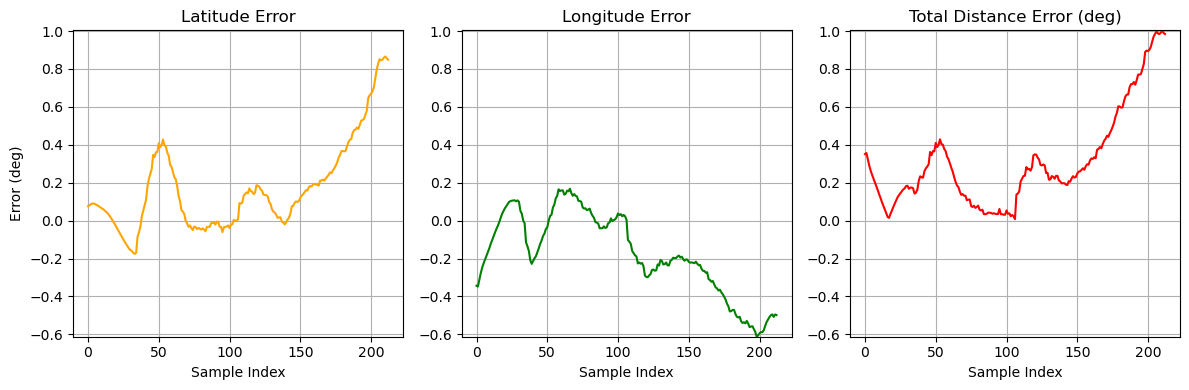

ÌèâÍ∑† LAT(ÏúÑÎèÑ) Ïò§Ï∞® Î≤îÏúÑ: 0.20¬∞ (ÏïΩ 22.12km)
ÌèâÍ∑† LON(Í≤ΩÎèÑ) Ïò§Ï∞® Î≤îÏúÑ: 0.22¬∞ (ÏïΩ 19.60km)
ÌèâÍ∑† Ï†ÑÏ≤¥ ÏúÑÏπò Ïò§Ï∞® Î≤îÏúÑ: 0.31¬∞ (ÏïΩ 34.48km)


In [176]:
lat_err, lon_err, total_err = plot_prediction_errors(actual_path, pred_path)
# LAT(ÏúÑÎèÑ): yÍ∞í = ÏúÑÎèÑÏò§Ï∞® (ÏòàÏ∏°Í∞í-Ïã§Ï†úÍ∞í) / ÏúÑÎ°ú Í∞ÄÎ©¥ Î∂ÅÏ™Ω, ÏïÑÎûòÎ°ú Í∞ÄÎ©¥ ÎÇ®Ï™Ω
# LON(Í≤ΩÎèÑ): yÍ∞í = Í≤ΩÎèÑÏò§Ï∞® (ÏòàÏ∏°Í∞í-Ïã§Ï†úÍ∞í) / ÏôºÏ™ΩÏúºÎ°ú Í∞ÄÎ©¥ ÏÑúÏ™Ω, Ïò§Î•∏Ï™ΩÏúºÎ°ú Í∞ÄÎ©¥ ÎèôÏ™Ω
# ÌèâÍ∑† Ï†ÑÏ≤¥: LAT+LON Ïò§Ï∞®Î•º Ïú†ÌÅ¥Î¶¨Îìú Í±∞Î¶¨Î°ú Í≥ÑÏÇ∞, Í∞íÏù¥ ÏûëÏùÑÏàòÎ°ù Î™®Îç∏Ïù¥ Ï†ïÌôïÌûà ÏòàÏ∏°

# Î™®Îç∏ Î∂àÎü¨Ïò§Í∏∞

In [181]:
from tensorflow.keras.models import load_model

model = load_model('CNDAG_model.keras')

# Îã§Î•∏ ÌååÏùº(ÏÑ†Î∞ï) Î°úÎî© / Î™®Îç∏Ïóê Ï†ÅÏö©

In [183]:
# ÏãúÌÄÄÏä§ ÏÉùÏÑ± Ìï®Ïàò
import numpy as np

def multivariate_data(dataset, target, start_index, end_index, history_size, target_size, step, single_step=False):
    data, labels = [], []
    start_index = start_index + history_size

    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i - history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i + target_size])
        else:
            labels.append(target[i:i + target_size])
    return np.array(data), np.array(labels)

In [184]:
# ÏòàÏ∏° ÏàòÌñâ Ìï®Ïàò
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

def predict_from_file(csv_path, model_path, past_history=30, future_target=10, step=1):

    # 1. CSV Î∂àÎü¨Ïò§Í∏∞
    df = pd.read_csv(csv_path)
    df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
    df = df.sort_values('TIMESTAMP')
    features = df[['LAT', 'LON']].copy()

    # 2. Ïä§ÏºÄÏùºÎßÅ
    scaler = MinMaxScaler()
    features_scaled = scaler.fit_transform(features)

    # 3. Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞Ïóê ÎåÄÌïú Î∂ÑÌï† (ÏãúÌÄÄÏä§ ÏÉùÏÑ±)
    X_, y_ = multivariate_data(features_scaled, features_scaled,
                              start_index=0, end_index=None,
                              history_size=past_history,
                              target_size=future_target,
                              step=step,
                              single_step=True)

    # 4. Î™®Îç∏ Î∂àÎü¨Ïò§Í∏∞ & ÏòàÏ∏°
    model = load_model(model_path)
    y_pred_scaled = model.predict(X_)

    # 5. Ïó≠Ï†ïÍ∑úÌôî
    y_pred = scaler.inverse_transform(y_pred_scaled)
    y_true = scaler.inverse_transform(y_)

    # 6. R¬≤ Í≥ÑÏÇ∞
    r2_lat = r2_score(y_true[:, 0], y_pred[:, 0])
    r2_lon = r2_score(y_true[:, 1], y_pred[:, 1])

    print(f"üìà LAT R¬≤: {r2_lat:.4f}")
    print(f"üìà LON R¬≤: {r2_lon:.4f}")

    # 7. Ï†ÑÏ≤¥ Ïã§Ï†ú Í≤ΩÎ°úÎèÑ Î∞òÌôò
    true_path = features.values

    return true_path, y_pred, df

In [187]:
# ÏßÄÎèÑ ÏãúÍ∞ÅÌôî Ìï®Ïàò
import folium
from IPython.display import display

def plot_paths_on_map(true_path, pred_path, df):
    # Ï¢åÌëú float Î≥ÄÌôò
    true_coords = [(float(lat), float(lon)) for lat, lon in true_path]
    pred_coords = [(float(lat), float(lon)) for lat, lon in pred_path]

    # ÏßÄÎèÑ Ï§ëÏã¨
    center_lat = df['LAT'].mean()
    center_lon = df['LON'].mean()

    m = folium.Map(location=[center_lat, center_lon], zoom_start=9)
    folium.PolyLine(true_coords, color='red', weight=4, tooltip='Actual Path').add_to(m)
    folium.PolyLine(pred_coords, color='green', weight=4, tooltip='Predicted Path').add_to(m)
    m.fit_bounds(true_coords + pred_coords)

    display(m)

## Î™®Îç∏Ïóê Ï†ÅÏö© / ÏãúÍ∞ÅÌôî

In [191]:
# (1) Ï≤´ Î≤àÏß∏ ÏÑ†Î∞ïÏúºÎ°ú Î™®Îç∏ÏùÑ ÏÉùÏÑ±, Îëê Î≤àÏß∏ ÏÑ†Î∞ïÏóê Ï†ÅÏö©
# 1. ÏòàÏ∏° Ïã§Ìñâ
true_path, pred_path, df = predict_from_file(
    './datasets/KRPUS_CNDAG/42c578a0-ce4c-3cf7-977e-ece463542581.csv',
    'CNDAG_model.keras'
)

12/12 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 41ms/step
üìà LAT R¬≤: 0.9748
üìà LON R¬≤: 0.9421


In [209]:
# ÏßÄÎèÑÏóê Í∑∏Î¶¨Í∏∞
plot_paths_on_map(true_path, pred_path, df)

In [194]:
# (1) Ï≤´ Î≤àÏß∏ ÏÑ†Î∞ïÏúºÎ°ú Î™®Îç∏ÏùÑ ÏÉùÏÑ±, ÏÑ∏ Î≤àÏß∏ ÏÑ†Î∞ïÏóê Ï†ÅÏö©
# 1. ÏòàÏ∏° Ïã§Ìñâ
true_path, pred_path, df = predict_from_file(
    './datasets/KRPUS_CNDAG/a804036f-9377-3242-a11d-1b76dfa0dcec.csv',
    'CNDAG_model.keras'
)

7/7 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 68ms/step
üìà LAT R¬≤: 0.9446
üìà LON R¬≤: 0.9686


- ÌååÏùºÎ™Ö Î≥ÄÍ≤Ω
- Í≤∞Ï†ï Í≥ÑÏàò Î≥ÄÍ≤Ω (Í≥ºÍ±∞, ÎØ∏Îûò ÏãúÏ†ê)